In [28]:
# Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

Load Data 

In [29]:
current_path = os.getcwd()
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

In [30]:
print(ground_truth_table.head())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [31]:
print(training_metadata_table.head())

          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male


In [32]:
print(training_metadata_table.shape)
print(ground_truth_table.shape)

(25331, 5)
(25331, 10)


Text(0.5, 1.0, 'Gender of Patient')

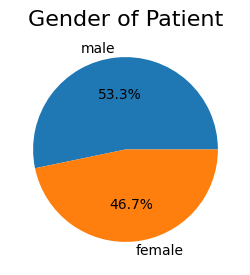

In [33]:
bar, ax = plt.subplots(figsize = (3,3))
plt.pie(training_metadata_table['sex'].value_counts(), labels = training_metadata_table['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

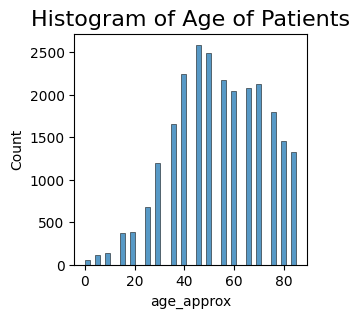

In [34]:
bar, ax = plt.subplots(figsize=(3, 3))
sns.histplot(training_metadata_table['age_approx'])
plt.title('Histogram of Age of Patients', size=16)

In [35]:
ground_truth_table.replace(['NaN', 'N/A', 'NA', 'n/a', 'n.a.', 'N#A', 'n#a', '?'], 'other', inplace=True)
missing_df =  ground_truth_table.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_df["% of Missing Values"] = round((missing_df["Total No. of Missing Values"]/len( ground_truth_table))*100,2)
missing_df

,Total No. of Missing Values,% of Missing Values
image,0,0.0
MEL,0,0.0
NV,0,0.0
BCC,0,0.0
AK,0,0.0
BKL,0,0.0
DF,0,0.0
VASC,0,0.0
SCC,0,0.0
UNK,0,0.0


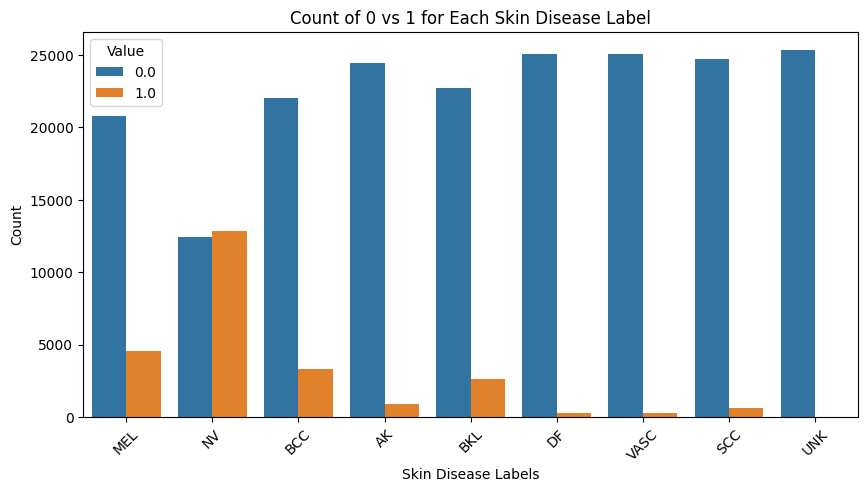

In [41]:
melted_df = pd.melt(ground_truth_table, id_vars=['image'], var_name='Label', value_name='Value')

plt.figure(figsize=(10, 5)) 
sns.countplot(x='Label', hue='Value', data=melted_df)
plt.title('Count of 0 vs 1 for Each Skin Disease Label')
plt.xlabel('Skin Disease Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()